In this notebook, we will try the process of implementing CNN with Keras in order to classify images.

I.   **Firstly**, we'll import useful packages.

II.   **Then**, we'll load the data, before visualize and preprocess it.

III.  **We'll try a simple CNN model** and then we will evaluate its performances.

IV.   **Finally,** we'll use techniques such as data augmentation, learning rate decay and dropout to increase our test F1.

# I. Let import all useful packages.

In [1]:
import os
import random
import datetime
import time
import subprocess
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow.keras.optimizers as Optimizer
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import cv2


In [2]:
if 'COLAB_GPU' in os.environ:
    !pip install ipython-autotime
else:
    print("I'm running on JupyterLab")


I'm running on JupyterLab


In [3]:
%load_ext autoreload
%autoreload 2
%load_ext autotime
%load_ext tensorboard
%matplotlib inline


time: 0 ns


**Task 1:** Setting Fre GPU in this Google Colab notebook.

[*Hint.*](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)

## Mounting Google Drive locally
**Task 2:** Mount the Google Driver into the Google Colab Driver.

[*Hint.*](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=eikfzi8ZT_rW)

In [4]:
## TYPE YOUR CODE for task 2 here:
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/gdrive')
else:
    print("I'm running on JupyterLab")


I'm running on JupyterLab
time: 0 ns


**Task 3**: Copy the zip dataset from Google Drive into Colab, then unzip it and finally remove the zip file to free up space.

[*Hint.*](https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf)

In [5]:
## TYPE YOUR CODE for task 3 here:
if 'COLAB_GPU' in os.environ:
    zip_path = '/content/gdrive/My Drive/FUNIX_ASM_1/image-classification.zip'
    !cp "{zip_path}"  .
    !unzip -q  image-classification.zip
    !rm image-classification.zip
else:
    print("I'm running on JupyterLab")


I'm running on JupyterLab
time: 0 ns


# II. Load the data.

## About dataset.
This is image data of Natural Scenes around the world.
This Data contains around 25k images of size 150x150 distributed under 6 categories. {'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test.


Now, We need to prepare our data to feed into the model. There is a builtin method in Keras that can extract your images from folder.

Following is the gernalized functions used to extract data from the directory.

In [6]:
# Here's our 6 categories that we have to classify.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {'buildings': 0,
                    'forest' : 1,
                    'glacier' : 2,
                    'mountain' : 3,
                    'sea' : 4,
                    'street' : 5
                    }
nb_classes = 6

time: 0 ns


## Loading the Data

**Task 4:** We have to write a load_data function that load the training and test data ( which contain images and the labels) from the folder.

* **Load_data** function return **train_set** and **test_set**. Each set contains **images and labels**.
* Apply 2 augmentation transformations (**shear_range** = 0.2, **zoom_range** = 0.2), shuffle with seed = 8 and rescaling function( to [0, 1]) to **train_set.**
* Apply rescaling funtion to [0, 1]  to **test_set**, no shuffle.
* Batch size = 32.



[*Hint.*](https://keras.io/preprocessing/image/)


In [7]:
def load_data(data_directories, batch_size=32, shear_range=0.2, zoom_range=0.2, horizontal_flip=False, vertical_flip=False):
    """
        Load the data:
            - 14,034 images to train the network.
            - 3000 images to evaluate how accurately the network learned to classify images.
        Input:
            Data directory.
        Return: 
            training_set, test_dataset.
    """
    ## TYPE YOUR CODE for task 4 here:
    train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2, #np.rad2deg(0.2),
                    zoom_range=0.2,
                    horizontal_flip=horizontal_flip,
                    vertical_flip=vertical_flip
                    )
   
    train_dataset = train_datagen.flow_from_directory(
            data_directories[0],
            target_size=(150, 150),
            batch_size=batch_size,
            shuffle=True,
            seed=8,
            class_mode='categorical')

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_dataset = test_datagen.flow_from_directory(
            data_directories[1],
            target_size=(150, 150),
            batch_size=batch_size,
            shuffle = False,
            class_mode='categorical')
    
    class_dictionary = train_dataset.class_indices 
    print('check class: ', class_dictionary) 

    return train_dataset, test_dataset


data_directories = ['seg_train/seg_train/', 'seg_test/seg_test/']
train_dataset, test_dataset = load_data(data_directories)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
check class:  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
time: 1.17 s


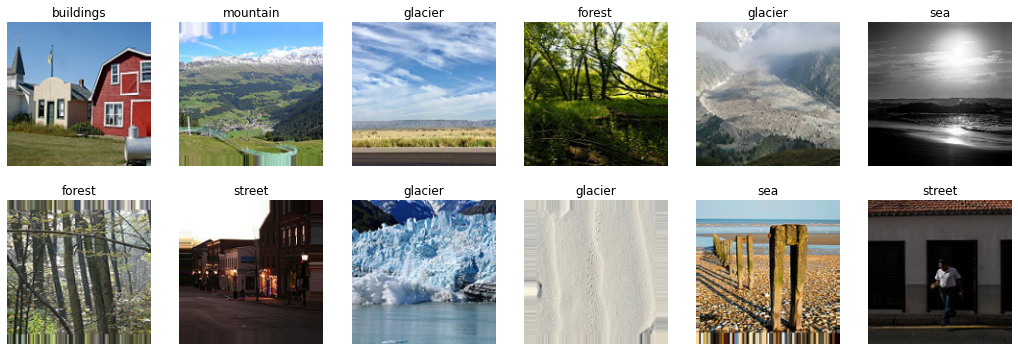

time: 1.14 s


In [8]:
# Check output of ImageDataGenerator
class_dictionary = train_dataset.class_indices
X, y = train_dataset.next()
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
for i, ax in enumerate(axes.flat):
    image = X[i]
    index = np.argmax(y[i])
    keys = list(class_dictionary.keys())
    vals = list(class_dictionary.values())
    label = keys[vals.index(index)]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')
    

## Let's explore the dataset.
We can, for example, ask ourselves:

* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

As you see, The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If you didnot resize the images to same size. It should be (No. of images,) shape. So, using this shape you cant feed the images to the model.


**Task 5:** Print out:

*  Number of training examples.
*  Number of testing examples.
* Size of each image.



In [9]:
## TYPE YOUR CODE for task 5 here:
print('Number of training examples:', train_dataset.samples)
print('Number of testing examples:', test_dataset.samples)
print('Size of each image:', train_dataset.image_shape)


Number of training examples: 14034
Number of testing examples: 3000
Size of each image: (150, 150, 3)
time: 0 ns


**Task 6:** Plot a pie chart of the proportion of each class.
You need to show the name and proportion of each class on the pie chart.

*Hint:* [plot.pie](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py)

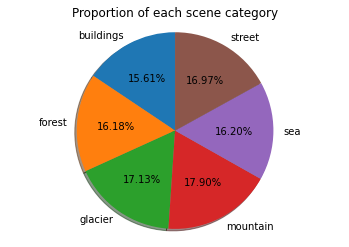

time: 172 ms


In [10]:
import collections

def plot_pie(train_dataset, class_names):
    ## TYPE YOUR CODE for task 6 here:
    counter = collections.Counter(train_dataset.classes)
    fig, ax = plt.subplots()
    ax.pie(counter.values(), labels=class_names, autopct='%.2f%%',
           shadow=True, startangle=90)
    ax.axis('equal')  
    ax.set_title('Proportion of each scene category')
    plt.show()

plot_pie(train_dataset, class_names)


**Task 7**: Display the 36 random images from the training set.

* Each class contain 6 random images.
* Bellow the image, show the class it belongs to.

*Hint*: [plot.imshow](https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_demo.html)

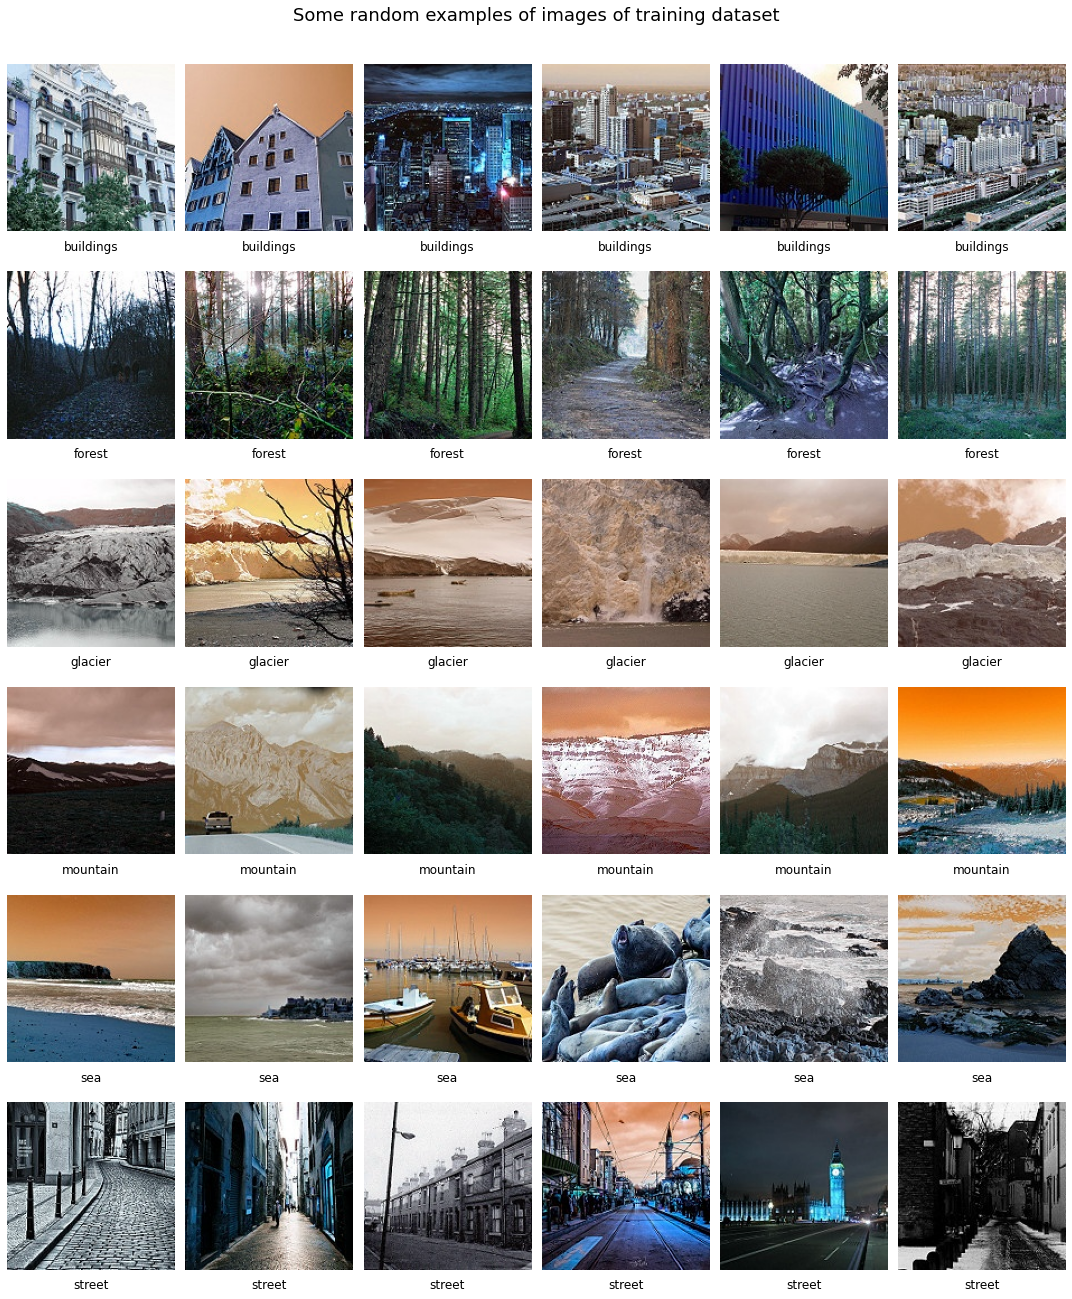

time: 2.45 s


In [11]:
from glob import glob

def visualize_image(train_directory):
    ## TYPE YOUR CODE for task 7 here:
    fig, axes = plt.subplots(6, 6, figsize=(15, 18))
    for row, class_name in enumerate(class_names):
        path = train_directory+class_name+'/**'
        all_path_files = glob(path)
        file_names = random.sample(all_path_files, 6)
        for col, file_name in enumerate(file_names):
            axes[row][col].imshow(cv2.imread(file_name))
            axes[row][col].axis('off') 
            axes[row][col].set_title(class_name, y=-0.15) 
            
    plt.suptitle('Some random examples of images of training dataset', size=18, y=1.0)
    plt.tight_layout()
    plt.show()

train_directory = 'seg_train/seg_train/'
visualize_image(train_directory)


# III. Modelling
## There are some steps we need to finish:
* Build the model.

* Compile the model.

* Train / fit the data to the model.

* Evaluate the model on the testing set.


## Build the model
We can build an easy model composed of different layers such as:

* [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

* [MaxPooling2D:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) The images get smaller sized.

* [Flatten:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.

* [Relu:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU) given a value x, returns max(x, 0).

* [Softmax:](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Softmax) 6 neurons, probability that the image belongs to one of the classes.

* [Dense.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

* [Dropout.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

**Task 8**: Buil a model, which contain these layers:
- Layer 1: Conv2D, 8 filters, kernel_size = (3, 3), activation = 'relu', input_shape = image_shape, same padding.
- Layer 2: Conv2D, 16 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 3: MaxPooling2D, pooling size = (2, 2).
- Layer 4: Conv2D, 32 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 5: Conv2D, 64 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 6: MaxPooling2D, pooling size = (3, 3).
- Layer 7: Conv2D, 128 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 8: Conv2D, 256 filters, kernel_size = (3, 3), activation = 'relu', same padding.
- Layer 9: MaxPooling2D, pooling size = (5, 5).
- Layer 10: Flatten.
- Layer 11: Dense with number of unit = 100, activation = 'relu'.
- Layer 12: Dropout with probs = 0.5.
- Layer 13: Final dense with number of unit = number of class, activation = 'softmax'.



All the Conv2D and Dense layers are followed by a Batch Norm layer with customized configuration excepts from the last dense layer:

- momentum=0.95 
- epsilon=0.005
- beta_initializer = RandomNormal with mean = 0 and stddev = 0.05
- gammaa_initializer = Constant with value = 0.9


In [12]:

def BatchNorm():
    return BatchNormalization(
                momentum=0.95, 
                epsilon=0.005,
                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                gamma_initializer=Constant(value=0.9)
                )

def create_model(input_shape=(150, 150, 3)):
    '''
    Return: 
        CNN model with 13 layers.
    '''
    
    model = Sequential()
    ## TYPE YOUR CODE for task 8 here:
    model.add(Conv2D(8, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=input_shape,))
    model.add(BatchNorm(),)
    model.add(Conv2D(16, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(MaxPooling2D(2))
    
    model.add(Conv2D(32, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(MaxPooling2D(3))
    
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(MaxPooling2D(5))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.5))
    
    model.add(Dense(6, activation='softmax'))
        
    return model
              
model = create_model()


time: 2.05 s


**Task 9:** Compile the model. Then print out the model summary.
* [Compile](https://keras.io/models/model/#compile) the model with Adam Optimizaer, lr = 1e-4, categorical-crossentroy loss and "[F1 score](https://github.com/tensorflow/addons/issues/825)" as metric.
* Print out the model F1.

In [13]:
def optimize(model):
    '''
    Input: 
        Model.
    Return: 
        Complied model.
    '''
    ## TYPE YOUR CODE for task 9 here:
    model.compile(optimizer=Optimizer.Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=[tfa.metrics.F1Score(num_classes=6,
                                               average="micro",
                                               threshold=0.5)])
    
    return model

model = optimize(model)
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 32)        1

**Task 10**: Setup callback.
* Create the [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to save the logs.
* Create the [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) to save the checkpoint with the best F1 after each epoch. 
* Create the [ReduceLROnPlateau callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) to reduce learning rate when the validation F1 score has stopped improving with the factor of 0.1 and patience = 2.

In [14]:
def get_best_result(checkpoint_name):
    from glob import glob
    import operator
    path = checkpoint_name+'**'
    all_path_files = glob(path)
    results = {}
    for file in all_path_files:
        results[file] = float(file[-9:-5])
    best_file = max(results.items(), key=operator.itemgetter(1))[0]
    return best_file


time: 0 ns


In [15]:
def callback_model(checkpoint_name, logdir):
    '''
    Input: 
        Best checkpoint name, logs name.
    Return: 
        Callback list, which contains tensorboard callback and checkpoint callback.
    '''
    ## TYPE YOUR CODE for task 10 here:
    logdir = os.path.join(logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
    
    checkpoint_name = checkpoint_name + '-{epoch:02d}-{val_f1_score:.2f}.hdf5'
    checkpoint = ModelCheckpoint(checkpoint_name,
                                 monitor='val_f1_score',
                                 save_best_only=False,
                                 mode='max',
                                 verbose=1)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_f1_score',
                                  factor=0.1,
                                  patience=2,
                                  verbose=1)
    
    callbacks_list = [tensorboard_callback, checkpoint, reduce_lr]
    
    return callbacks_list

#%rmdir /q/s training_logs
checkpoint_name = 'weights-improvement'
baseDir = os.path.abspath(os.getcwd())
logs_name = 'training_logs'
logdir = os.path.join(baseDir, logs_name)
callbacks_list = callback_model(checkpoint_name, logdir)


time: 0 ns


**Task 11:** Train the model.

**Requirement:** 
* Train the model with 10 epochs, generator = train_dataset, validation_data = test_dataset.
* Return the model with best-checkpoint weights.

*Hint:*
[Fit](https://keras.io/models/sequential/#fit_generator) the model first, then reload the model ([load_model function](https://keras.io/getting-started/faq/)) with best-checkpoint weights.

In [16]:
# Create function train_model
def train_model(model, train_dataset, test_dataset, callbacks_list, epochs=10, batch_size=32):
    '''
    Input: 
        Model and callback list,
    Return: 
        Model with best-checkpoint weights.
    '''
    ## TYPE YOUR CODE for task 11 here:
    # Clear old folder
    %rmdir /q/s {logs_name}
    # Clear old file
    path = checkpoint_name + '**'
    all_path_files = glob(path)
    for file in all_path_files:
        os.remove(file)
    # fit model
    model.fit(train_dataset,
              steps_per_epoch=train_dataset.samples/batch_size, 
              validation_data=test_dataset,
              validation_steps=test_dataset.samples/batch_size,
              epochs=epochs,
              callbacks=callbacks_list)
    
    # Return model with best-checkpoint weights
    del model
    best_file = get_best_result(checkpoint_name)
    model = load_model(best_file)
    return model


time: 0 ns


In [17]:
# Train model
model = create_model()
model = optimize(model)
model = train_model(model, train_dataset, test_dataset, callbacks_list, epochs=10)


Epoch 1/10
  1/438 [..............................] - ETA: 0s - loss: 2.9823 - f1_score: 0.1224WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
439/438 [==============================] - ETA: 0s - loss: 1.0805 - f1_score: 0.5860
Epoch 00001: saving model to weights-improvement-01-0.71.hdf5
439/438 [==============================] - 193s 439ms/step - loss: 1.0805 - f1_score: 0.5860 - val_loss: 0.7900 - val_f1_score: 0.7142
Epoch 2/10
439/438 [==============================] - ETA: 0s - loss: 0.7784 - f1_score: 0.7032
Epoch 00002: saving model to weights-improvement-02-0.78.hdf5
439/438 [==============================] - 78s 177ms/step - loss: 0.7784 - f1_score: 0.7032 - val_loss: 0.6292 - val_f1_score: 0.7777
Epoch 3/10
439/438 [=================

In [18]:
_, F1 = model.evaluate(test_dataset, verbose=1)
F1

94/94 [==============================] - 3s 36ms/step - loss: 0.5048 - f1_score: 0.8170


0.8170391321182251

time: 3.72 s


######################################################################

**Task 12**: [Show the tensorboard](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) in the notebook.

In [19]:
## TYPE YOUR CODE for task 12 here:
#!kill 685
if 'COLAB_GPU' in os.environ:
    %tensorboard --logdir {logdir}
else:
    proc = subprocess.Popen(["tensorboard", "--logdir", logdir])
    # wait process
    time.sleep(5)
    %tensorboard --logdir {logdir}
    #%tensorboard --logdir {logdir}


Reusing TensorBoard on port 6006 (pid 7300), started 4 days, 1:11:51 ago. (Use '!kill 7300' to kill it.)

time: 5.06 s


**Task 13:** Prediction on test set.
* Complete the get_prediction_classes function.
* Print out the test F1. 

In [20]:
def get_prediction_classes(model, prediction_dataset):
    ## TYPE YOUR CODE for task 13 here:
    '''
    Input: 
        Model and prediction dataset.
    Return: 
        Prediction list and groundtrurth list with predicted classes.
    '''
    test_groundtruths = prediction_dataset.classes
    test_predictions = np.argmax(model.predict(prediction_dataset), axis=-1)
       
    return test_groundtruths, test_predictions
    
test_groundtruths, test_predictions = get_prediction_classes(model, test_dataset) 
_, F1 = model.evaluate(test_dataset, verbose=0)
print('F1 score', F1)


F1 score 0.8170391321182251
time: 6.67 s


**Task 14:** Perform the predicted result on test set using confusion matrix.
Remember to show the class name in the confusion matrix. 

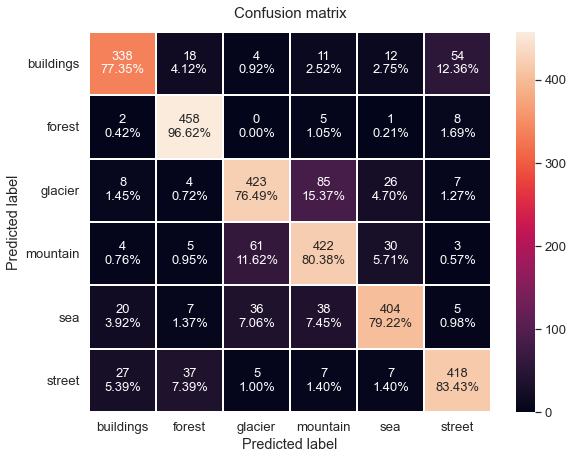

time: 719 ms


In [21]:

sns.set(font_scale=1.2, style='dark')

def plot_confusion_matrix(groundtruth, predictions, class_names):
    ## TYPE YOUR CODE for task 14 here:
    cm = confusion_matrix(groundtruth, predictions, normalize=None)
    cm_rate = confusion_matrix(groundtruth, predictions, normalize='true')
    
    values = ['{0:0.0f}'.format(value) for value in cm.flatten()] 
    percentages = ["{0:.2%}".format(value) for value in cm_rate.flatten()]
    labels = [f'{v}\n{p}' for v, p in zip(values, percentages)]
    labels = np.array(labels).reshape(6, 6)
    
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=labels, fmt="", annot_kws={"size": 13}, xticklabels=class_names, yticklabels=class_names, linewidths=1) 
    plt.title('Confusion matrix', y=1.02, size=15)
    plt.xlabel('Predicted label')
    plt.ylabel('Predicted label')
    plt.yticks(rotation=0)
    plt.show()
    
plot_confusion_matrix(test_groundtruths, test_predictions, class_names)


**Task 15**: Model finetuning - fine tune the model using some of these approachs:
* Increase max epochs, change batch size.
* Play around with CNN, Dense and Dropoutlayers (add/# units/etc).
* Increase data augmentation transformations.
* Try to use a [pretrained model](https://www.tensorflow.org/api_docs/python/tf/keras/applications) on Keras.

Requirement: The val_best_F1 should be higher than 87%.

#### 1. Increase max epochs, change batch size.

In [22]:
## TYPE YOUR CODE for task 15 here:

batch_size = 16
num_epochs = 15
train_dataset, test_dataset = load_data(data_directories, batch_size=batch_size)
model_2 = create_model()
model_2 = optimize(model_2)
model_2 = train_model(model_2, train_dataset, test_dataset, callbacks_list, epochs=num_epochs, batch_size=batch_size)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
check class:  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Epoch 1/15
878/877 [==============================] - ETA: 0s - loss: 1.0256 - f1_score: 0.6033
Epoch 00001: saving model to weights-improvement-01-0.74.hdf5
878/877 [==============================] - 89s 101ms/step - loss: 1.0256 - f1_score: 0.6033 - val_loss: 0.6968 - val_f1_score: 0.7419
Epoch 2/15
878/877 [==============================] - ETA: 0s - loss: 0.7591 - f1_score: 0.7125 ETA: 0s - loss: 0.7589 - 
Epoch 00002: saving model to weights-improvement-02-0.79.hdf5
878/877 [==============================] - 90s 103ms/step - loss: 0.7591 - f1_score: 0.7125 - val_loss: 0.5961 - val_f1_score: 0.7870
Epoch 3/15
878/877 [==============================] - ETA: 0s - loss: 0.6842 - f1_score: 0.7444
Epoch 00003: saving model to weights-improvement-03-0.79.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning r

In [23]:
_, F1 = model_2.evaluate(test_dataset, verbose=1)
F1

188/188 [==============================] - 4s 20ms/step - loss: 0.4905 - f1_score: 0.8259


0.8258690237998962

time: 4 s


- <span style="color:blue"> Nhận xét:
    - Độ chính xác tăng khi giảm batch size tuy nhiên tốc độ train lại tăng, mặt khác độ chính xác tăng cũng không nhiều, cần nghiên cứu cách tiếp cận mới

#### 2. Tăng Layer Dense và số unit của từng layer

In [24]:
# Create new model function
def create_model_3(input_shape=(150, 150, 3)):
        
    model = Sequential()
    ## TYPE YOUR CODE for task 8 here:
    model.add(Conv2D(8, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=input_shape,))
    model.add(BatchNorm(),)
    model.add(Conv2D(16, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(MaxPooling2D(2))
    
    model.add(Conv2D(32, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(MaxPooling2D(3))
    
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same", activation='relu'))
    model.add(BatchNorm())
    model.add(MaxPooling2D(5))
    
    model.add(Flatten())
    # Tăng unit
    model.add(Dense(200, activation='relu'))
    model.add(BatchNorm())
    # Thêm Layer Dense
    model.add(Dense(200, activation='relu'))
    model.add(BatchNorm())
    #model.add(Dropout(0.5))
    
    model.add(Dense(6, activation='softmax'))
        
    return model


time: 0 ns


In [25]:
# Buil a new model
model_3 = create_model_3()
model_3 = optimize(model_3)
model_3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 150, 150, 8)       224       
_________________________________________________________________
batch_normalization_21 (Batc (None, 150, 150, 8)       32        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 150, 150, 16)      1168      
_________________________________________________________________
batch_normalization_22 (Batc (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
batch_normalization_23 (Batc (None, 75, 75, 32)       

In [26]:
# train model
train_dataset, test_dataset = load_data(data_directories)
model_3 = train_model(model_3, train_dataset, test_dataset, callbacks_list)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
check class:  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Epoch 1/10
439/438 [==============================] - ETA: 0s - loss: 0.9231 - f1_score: 0.6485
Epoch 00001: saving model to weights-improvement-01-0.71.hdf5
439/438 [==============================] - 79s 179ms/step - loss: 0.9231 - f1_score: 0.6485 - val_loss: 0.7930 - val_f1_score: 0.7058
Epoch 2/10
439/438 [==============================] - ETA: 0s - loss: 0.6410 - f1_score: 0.7599
Epoch 00002: saving model to weights-improvement-02-0.72.hdf5
439/438 [==============================] - 78s 177ms/step - loss: 0.6410 - f1_score: 0.7599 - val_loss: 0.7533 - val_f1_score: 0.7219
Epoch 3/10
439/438 [==============================] - ETA: 0s - loss: 0.5252 - f1_score: 0.8068
Epoch 00003: saving model to weights-improvement-03-0.79.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-

In [27]:
# Evaluate model
_, F1 = model_3.evaluate(test_dataset, verbose=1)
F1

94/94 [==============================] - 3s 37ms/step - loss: 0.5049 - f1_score: 0.8167


0.8166781067848206

time: 3.81 s


- <span style="color:blue"> Nhận xét:
    - Độ chính xác khi train tăng không đáng kể ngay cả khi không dùng Dropout

#### 3. Increase data augmentation transformations

In [28]:
# Create data augmentation and train model
train_dataset, test_dataset = load_data(data_directories,
                      shear_range=10,
                      zoom_range=0.5,
                      horizontal_flip=True,
                      vertical_flip=True
                        )
model_4 = create_model()
model_4 = optimize(model_4)
model_4 = train_model(model_4, train_dataset, test_dataset, callbacks_list)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
check class:  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Epoch 1/10
439/438 [==============================] - ETA: 0s - loss: 1.2445 - f1_score: 0.5214
Epoch 00001: saving model to weights-improvement-01-0.67.hdf5
439/438 [==============================] - 79s 179ms/step - loss: 1.2445 - f1_score: 0.5214 - val_loss: 0.9116 - val_f1_score: 0.6662
Epoch 2/10
439/438 [==============================] - ETA: 0s - loss: 0.9262 - f1_score: 0.6393
Epoch 00002: saving model to weights-improvement-02-0.68.hdf5
439/438 [==============================] - 76s 174ms/step - loss: 0.9262 - f1_score: 0.6393 - val_loss: 0.8427 - val_f1_score: 0.6817
Epoch 3/10
439/438 [==============================] - ETA: 0s - loss: 0.7924 - f1_score: 0.6941
Epoch 00003: saving model to weights-improvement-03-0.76.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-

In [29]:
# Evaluate model
_, F1 = model_4.evaluate(test_dataset, verbose=1)
F1

94/94 [==============================] - 3s 36ms/step - loss: 0.6171 - f1_score: 0.7666


0.7665960192680359

time: 3.76 s


- <span style="color:blue"> Nhận xét:
    - Độ chính xác không được cải thiện

#### 4. Try to use a pretrained model on Keras

In [30]:
# Import pretrained model
from tensorflow.keras.applications import VGG19, ResNet50, DenseNet201, InceptionV3, MobileNet


time: 0 ns


In [31]:

input_shape = (150, 150, 3)

def get_model(app, summary=False):
   
    pretrained_model = app(
            include_top=False,
            input_shape=input_shape,
            weights='imagenet'
            )
    output = Flatten()(pretrained_model.output)
   
    output = Dense(128, activation='relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    output = Dense(6, activation='softmax')(output)
    model = Model(pretrained_model.input, output)
   
    if summary:
        model.summary(line_length=100)

    model = optimize(model)
    
    return model
    

time: 15 ms


In [32]:
# Train models
apps = [VGG19, ResNet50, DenseNet201, InceptionV3, MobileNet]
results = {}
batch_size=32
train_dataset, test_dataset = load_data(data_directories, batch_size=batch_size)

for app in apps:
    # Create model
    model = get_model(app, summary=False)
    # Train model
    print('Start training model', app.__name__)
    start = time.time()
    model = train_model(model, train_dataset, test_dataset, callbacks_list, epochs=5, batch_size=batch_size)
    # Evaluate
    _, acc = model.evaluate(test_dataset, verbose=1)
    stop = time.time()
    print('End training model', app.__name__)
    duration = stop - start
    results[app.__name__] = [acc, duration]

df_result = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy(%)', 'Duration(s)'])
df_result.index.name = 'App'
df_result.reset_index(inplace=True)
df_result.to_csv('train_result.csv', index=False)
df_result
    

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
check class:  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Start training model VGG19
Epoch 1/5
439/438 [==============================] - ETA: 0s - loss: 0.6412 - f1_score: 0.7707
Epoch 00001: saving model to weights-improvement-01-0.78.hdf5
439/438 [==============================] - 328s 748ms/step - loss: 0.6412 - f1_score: 0.7707 - val_loss: 0.6614 - val_f1_score: 0.7841
Epoch 2/5
439/438 [==============================] - ETA: 0s - loss: 0.3813 - f1_score: 0.8711
Epoch 00002: saving model to weights-improvement-02-0.85.hdf5
439/438 [==============================] - 169s 385ms/step - loss: 0.3813 - f1_score: 0.8711 - val_loss: 0.4619 - val_f1_score: 0.8544
Epoch 3/5
439/438 [==============================] - ETA: 0s - loss: 0.3238 - f1_score: 0.8937
Epoch 00003: saving model to weights-improvement-03-0.82.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning r

,App,Accuracy(%),Duration(s)
0,VGG19,0.919328,1018.935091
1,ResNet50,0.936028,708.816289
2,DenseNet201,0.927270,1015.981967
3,InceptionV3,0.927866,574.176584
4,MobileNet,0.925988,506.827116


time: 1h 3min 58s


- <span style="color:blue"> Nhận xét:
    - Độ chính xác được cải thiện rất nhiều khi dùng pre-trained model, các mạng có độ chính xác tương đương nhau tuy nhiên mạng MobileNet có tốc độ nhanh hơn cả